# SOLAR RADIATION PREDICTION

### Authors: 
*Aniket Chaudhary || Manasi Chhibber*

### Link to the dataset: https://www.kaggle.com/dronio/SolarEnergy

### Understanding the Problem and Data
Solar irradiance is the power per unit area received from the Sun in the form of electromagnetic radiation as reported in the wavelength range of the measuring instrument. The solar irradiance is measured in watt per square metre (W/m2) in SI units. Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2) during that time period. This integrated solar irradiance is called solar irradiation, solar exposure, solar insolation, or insolation.

The dataset includes observations of:

- Solar Irradiance (W/m2)
- Temperature (°F)
- Barometric Pressure (Hg)
- Humidity (%)
- Wind Direction (°)
- Wind Speed (mph)
- Sun Rise/Set Time

It contains measurements for the 4 months (2016-09-01 to 2016-12-31) [Pacific/Honolulu] and the aim is to predict the level of solar radiation.

### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

# importing multiple models
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

# for accuracy check
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn import preprocessing

### Getting our Data

In [2]:
df = pd.read_csv(r'SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


### Data Preprocessing

In [3]:
# to see number of missing elements, use df.isnull().sum()
df.isnull().any() 

UNIXTime                  False
Data                      False
Time                      False
Radiation                 False
Temperature               False
Pressure                  False
Humidity                  False
WindDirection(Degrees)    False
Speed                     False
TimeSunRise               False
TimeSunSet                False
dtype: bool

In [4]:
# some attributes are not of our use, dropping them
df = df.drop(['TimeSunRise','TimeSunSet','UNIXTime','Data','Time'], axis=1)
df

,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed
0,1.21,48,30.46,59,177.39,5.62
1,1.21,48,30.46,58,176.78,3.37
2,1.23,48,30.46,57,158.75,3.37
3,1.21,48,30.46,60,137.71,3.37
4,1.17,48,30.46,62,104.95,5.62
...,...,...,...,...,...,...
32681,1.22,44,30.43,102,145.42,6.75
32682,1.17,44,30.42,102,117.78,6.75
32683,1.20,44,30.42,102,145.19,9.00
32684,1.23,44,30.42,101,164.19,7.87


In [5]:
# checking for variance inflation factor
variables = df[['Temperature','Pressure','Humidity','Speed','WindDirection(Degrees)']]
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(variables.values, i) for i in range(variables.shape[1])]
vif['Features'] = variables.columns

In [6]:
vif
# The VIF for Pressure is so high, that it influences Temperature's variance to swell, hence pressure is dropped and VIF
# calculated again

,VIF,Features
0,82.077639,Temperature
1,129.064887,Pressure
2,10.731528,Humidity
3,4.445383,Speed
4,4.292385,WindDirection(Degrees)


In [7]:
df = df.drop('Pressure', axis=1)
df  # new dataset after dropping 'Pressure' attribute

,Radiation,Temperature,Humidity,WindDirection(Degrees),Speed
0,1.21,48,59,177.39,5.62
1,1.21,48,58,176.78,3.37
2,1.23,48,57,158.75,3.37
3,1.21,48,60,137.71,3.37
4,1.17,48,62,104.95,5.62
...,...,...,...,...,...
32681,1.22,44,102,145.42,6.75
32682,1.17,44,102,117.78,6.75
32683,1.20,44,102,145.19,9.00
32684,1.23,44,101,164.19,7.87


In [8]:
variables_1 = df[['Temperature','Humidity','Speed','WindDirection(Degrees)']]
vif_1 = pd.DataFrame()
vif_1['VIF'] = [variance_inflation_factor(variables_1.values, i) for i in range(variables_1.shape[1])]
vif_1['Features'] = variables_1.columns

In [9]:
vif_1

# Though the VIF of Temp is still high, this is mainly because of inclusion of humidity since both have atleast some amount
# of correlation amongst each other. Also, dropping temp would lead to a deficit of a key factor used to check the radiation.
# Hence, we proceed with these four features itself.

,VIF,Features
0,11.246320,Temperature
1,7.372081,Humidity
2,4.101280,Speed
3,3.685892,WindDirection(Degrees)


<AxesSubplot:xlabel='Temperature'>

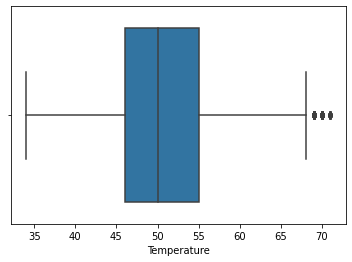

In [10]:
# checking for outliers in 'Temperature' attribute
sns.boxplot(x = df['Temperature'])

In [11]:
# some values >65 are present as outliers, replacing these values with the mean of the values in the attribute
outliers_removed = [x for x in df['Temperature'] if x > 65]
for i in df['Temperature']:
    if i in set(outliers_removed):
        df['Temperature'] = df['Temperature'].replace(i,df['Temperature'].mean())

<AxesSubplot:xlabel='Temperature'>

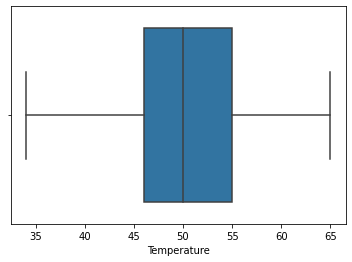

In [12]:
# let's see if the outliers are removed or not
sns.boxplot(x = df['Temperature'])

In [13]:
# no outliers now! moving on to other attributes

<AxesSubplot:xlabel='Humidity'>

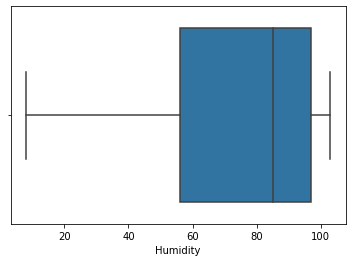

In [14]:
# checking for outliers in 'Humidity' attribute
sns.boxplot(x = df['Humidity'])

In [15]:
# no outliers, moving on to other attributes

<AxesSubplot:xlabel='Speed'>

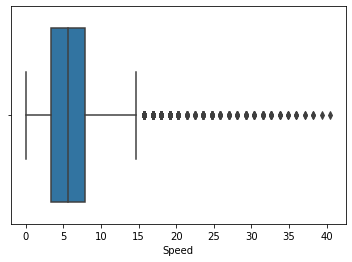

In [16]:
# checking for outliers in 'Speed' attribute
sns.boxplot(x = df['Speed'])

In [17]:
# a lot many values >15 are present as outliers, replacing these values with the mean of the values in the attribute
outliers_removed = [x for x in df['Speed'] if x > 15]
for i in df['Speed']:
    if i in set(outliers_removed):
        df['Speed'] = df['Speed'].replace(i,df['Speed'].mean())

<AxesSubplot:xlabel='Speed'>

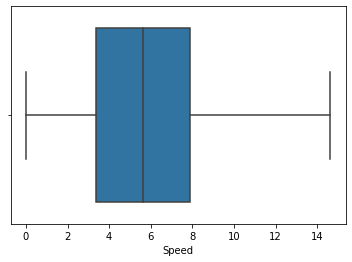

In [18]:
# let's see if the outliers are removed or not
sns.boxplot(x = df['Speed'])

In [19]:
# no outliers now! moving on to the last attribute

<AxesSubplot:xlabel='WindDirection(Degrees)'>

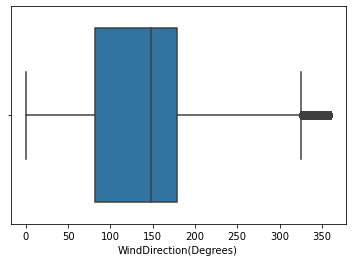

In [20]:
# checking for outliers in 'WindDirection(Degrees)' attribute
sns.boxplot(x = df['WindDirection(Degrees)'])

In [21]:
# a lot many values >300 are present as outliers, replacing these values with the mean of the values in the attribute
outliers_removed = [x for x in df['WindDirection(Degrees)'] if x > 300]
for i in df['WindDirection(Degrees)']:
    if i in set(outliers_removed):
        df['WindDirection(Degrees)'] = df['WindDirection(Degrees)'].replace(i,df['WindDirection(Degrees)'].mean())

<AxesSubplot:xlabel='WindDirection(Degrees)'>

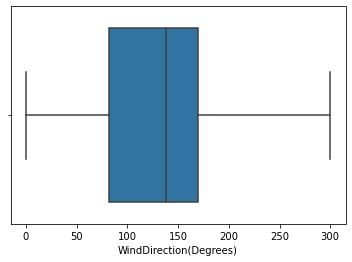

In [22]:
# let's see if the outliers are removed or not
sns.boxplot(x = df['WindDirection(Degrees)'])

In [23]:
# no outliers now! 

# this much preprocessing should suffice

### Data Visualization

(array([ 142.,  437., 1432., 6323., 7136., 5952., 3672., 3080., 2370.,
        2142.]),
 array([34. , 37.1, 40.2, 43.3, 46.4, 49.5, 52.6, 55.7, 58.8, 61.9, 65. ]),
 <BarContainer object of 10 artists>)

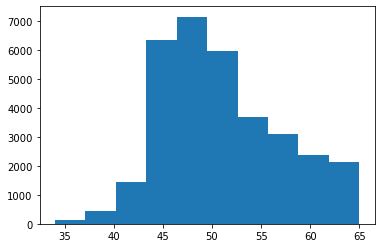

In [24]:
plt.hist(df['Temperature'])

In [25]:
# the data is almost normally distributed

(array([  308.,  1700.,  2331.,  1915.,  1891.,  2012.,  2417.,  3137.,
         6122., 10853.]),
 array([  8. ,  17.5,  27. ,  36.5,  46. ,  55.5,  65. ,  74.5,  84. ,
         93.5, 103. ]),
 <BarContainer object of 10 artists>)

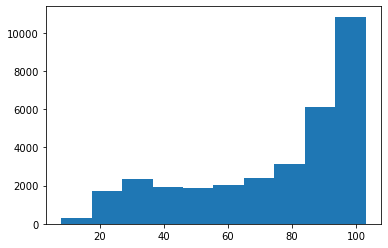

In [26]:
plt.hist(df['Humidity'])

In [27]:
# this is a lot right skewed, but ultimately our residuals should be normally distributed

(array([1865., 2777., 3874., 9112., 4805., 3550., 4224., 1084.,  691.,
         704.]),
 array([ 0.   ,  1.462,  2.924,  4.386,  5.848,  7.31 ,  8.772, 10.234,
        11.696, 13.158, 14.62 ]),
 <BarContainer object of 10 artists>)

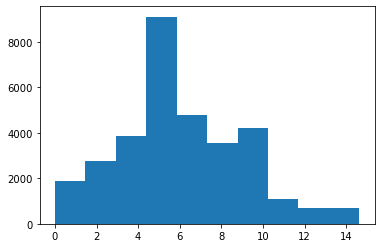

In [28]:
plt.hist(df['Speed'])

In [29]:
# almost normally distributed

(array([2830., 3156., 2955., 2978., 7390., 7905., 3457.,  877.,  516.,
         622.]),
 array([9.00000e-02, 3.00770e+01, 6.00640e+01, 9.00510e+01, 1.20038e+02,
        1.50025e+02, 1.80012e+02, 2.09999e+02, 2.39986e+02, 2.69973e+02,
        2.99960e+02]),
 <BarContainer object of 10 artists>)

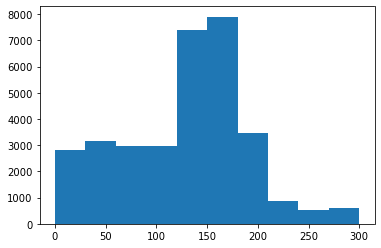

In [30]:
plt.hist(df['WindDirection(Degrees)'])

In [31]:
# the data is a little bit left skewed

In [32]:
df.columns

Index(['Radiation', 'Temperature', 'Humidity', 'WindDirection(Degrees)',
       'Speed'],
      dtype='object')

In [33]:
# now let's check the skewness mathematically
print('Skewness values:\n')
print('Humidity:', df['Humidity'].skew())
print('Temperature:', df['Temperature'].skew())
print('WindDirection(Degrees):', df['WindDirection(Degrees)'].skew())
print('Speed:', df['Speed'].skew())

Skewness values:

Humidity: -0.7762804152092764
Temperature: 0.44280545637306895
WindDirection(Degrees): -0.13215511315335787
Speed: 0.40773010106064744


In [34]:
# as the skewness in within range of acceptance, we do not need to do any transformations

<AxesSubplot:>

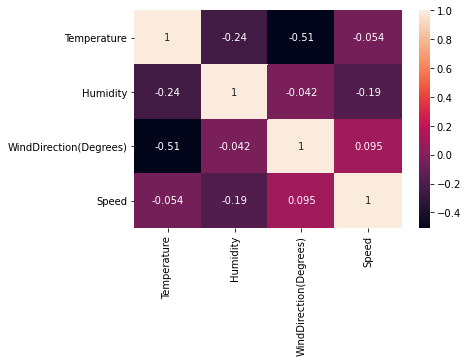

In [35]:
# using Pearson's correlation method to check for correlation
corr = df.drop(['Radiation'],axis = 1).corr(method='pearson')
sns.heatmap(corr, annot=True)

### Cross Validation

In [36]:
# we'll use K-Fold cross validation technique for selecting training & testing sets randomly for achieving the maximum accuracy
kf = KFold(shuffle=True, random_state=100)

In [37]:
data = df.values
X, y = data[:,1:], data[:,0]  # splitting and getting the independent attributes X and dependent attribute y

### 1. Linear Regression Model

Regression models are used to describe relationships between variables by fitting a line to the observed data. Regression allows you to estimate how a dependent variable changes as the independent variable(s) change.

The formula for a multiple linear regression is:

<img src = 'https://cdn.scribbr.com/wp-content/uploads/2020/02/multiple-linear-regression-formula.png'>

Where:

y = the predicted value of the dependent variable

B0 = the y-intercept (value of y when all other parameters are set to 0)

B1X1 = the regression coefficient (B1) of the first independent variable (X1) (a.k.a. the effect that increasing the value of the independent variable has on the predicted y value)

… = do the same for however many independent variables you are testing

BnXn = the regression coefficient of the last independent variable

e = model error (the variation that is there in our estimate of y)

In [38]:
scores = []
rmse = []
mae = []
    
# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]    
    
    model_1 = LinearRegression().fit(X_train, y_train)
    scores.append(model_1.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_1.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_1.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.52728
Mean RMSE: 217.17389
Mean MAE: 164.27125


### 2. XGBoost Regression Model

Extreme Gradient Boosting (XGBoost) is an open-source library that provides an efficient and effective implementation of the gradient boosting algorithm. Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems.

Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models. This is a type of ensemble machine learning model referred to as boosting.

<img src = 'https://docs.aws.amazon.com/sagemaker/latest/dg/images/xgboost_illustration.png'>

In [39]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]  
    
    model_2 = XGBRegressor(random_state=0).fit(X_train, y_train)
    scores.append(model_2.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_2.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_2.predict(X_test)))
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.70014
Mean RMSE: 172.97105
Mean MAE: 103.67554


### 3. Random Forest Regressor

Individual decision trees have high variance, but there’s been an observation that when we combine all of them together in parallel, then the final variance becomes less as every decision tree gets very nicely trained on specific sample data and so the output doesn’t depend on one decision tree rather multiple decision trees. In case of regression problems, the final result is the mean of all the results. This is called as ‘Aggregation’. A random forest model performs various tasks with the help of multiple decision trees and by using a technique called ‘Bagging’ which is a combination of ‘Bootstrap’ and ‘Aggregation’. ‘Bootstrap’ is the part where we perform random row and feature sampling from the dataset. These act as sample datasets for every model or basically individual decision tree.

<img src = 'https://media.geeksforgeeks.org/wp-content/uploads/20200516180708/Capture482.png'>

In [40]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_3 = RandomForestRegressor(random_state=0).fit(X_train, y_train)
    scores.append(model_3.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_3.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_3.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.68792
Mean RMSE: 176.46028
Mean MAE: 102.64306


### 4. Decision Tree Regressor

Decision tree regression observes features of an object and trains a model in the structure of a tree to predict data in the future to produce meaningful continuous output. For regression trees, the value of terminal nodes is the mean of the observations falling in that region. Therefore, if an unseen data point falls in that region, we predict using the mean value. Here's is an example:

<img src = 'https://www.saedsayad.com/images/Decision_tree_r1.png'>

In [41]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_4 = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
    scores.append(model_4.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_4.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_4.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.4301
Mean RMSE: 238.43539
Mean MAE: 125.74695


### 5. Gradient Boosting Regressor

Gradient Boosting algorithm is used to generate an ensemble model by combining the weak learners or weak predictive models. The process of fitting the model starts with the constant such as mean value of the target values. In subsequent stages, the decision trees or the estimators are fitted to predict the negative gradients of the samples. The gradients are updated in the each iterator (for every subsequent estimators). A learning rate is used to shrink the outcome or the contribution from each subsequent trees or estimators.

<img src = 'https://media.geeksforgeeks.org/wp-content/uploads/20200721214745/gradientboosting.PNG'>

In [42]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_5 = GradientBoostingRegressor(random_state=0).fit(X_train, y_train)
    scores.append(model_5.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_5.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_5.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.67627
Mean RMSE: 179.71824
Mean MAE: 112.79256


### 6. Light GBM Regressor

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

- Faster training speed and higher efficiency.
- Lower memory usage.
- Better accuracy.
- Support of parallel, distributed, and GPU learning.
- Capable of handling large-scale data.

Since it is based on decision tree algorithms, it splits the tree leaf wise with the best fit whereas other boosting algorithms split the tree depth wise or level wise rather than leaf-wise. So when growing on the same leaf in Light GBM, the leaf-wise algorithm can reduce more loss than the level-wise algorithm and hence results in much better accuracy which can rarely be achieved by any of the existing boosting algorithms. Also, it is surprisingly very fast, hence the word ‘Light’.

<img height = 500 width = 600 src = 'https://rohitgr7.github.io/content/images/2019/03/Screenshot-from-2019-03-27-23-09-47-1.png'>

In [43]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_6 = LGBMRegressor(random_state=0).fit(X_train, y_train)
    scores.append(model_6.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_6.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_6.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.70521
Mean RMSE: 171.50595
Mean MAE: 104.18902


### 7. Cat Boost Regressor

CatBoost builds upon the theory of decision trees and gradient boosting. The main idea of boosting is to sequentially combine many weak models (a model performing slightly better than random chance) and thus through greedy search create a strong competitive predictive model. Because gradient boosting fits the decision trees sequentially, the fitted trees will learn from the mistakes of former trees and hence reduce the errors. This process of adding a new function to existing ones is continued until the selected loss function is no longer minimized.

The oblivious tree procedure allows for a simple fitting scheme and efficiency on CPUs, while the tree structure operates as a regularization to find an optimal solution and avoid overfitting.

<img height = 600 width = 700 src = 'https://miro.medium.com/max/1400/1*AjrRnwvBuu-zK8CvEfM29w.png'>

In [44]:
scores = []
rmse = []
mae = []

# splitting for training & testing randomly
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    model_7 = CatBoostRegressor(random_state=0, silent=True).fit(X_train, y_train)
    scores.append(model_7.score(X_test, y_test))
    rmse.append(np.sqrt(mean_squared_error(y_test, model_7.predict(X_test))))
    mae.append(mean_absolute_error(y_test, model_7.predict(X_test)))
    
print('Mean R2 Score:', round(np.mean(scores), 5))
print('Mean RMSE:', round(np.mean(rmse), 5))
print('Mean MAE:', round(np.mean(mae), 5))

Mean R2 Score: 0.70762
Mean RMSE: 170.79891
Mean MAE: 103.30212


### Comparing the Performance of all the Models

+-------------------+---------------------+
| Algorithm Used    |   Accuracy Achieved |
+===================+=====================+
| Linear Regression |            0.520037 |
+-------------------+---------------------+
| XGBoost           |            0.69765  |
+-------------------+---------------------+
| Random Forest     |            0.688367 |
+-------------------+---------------------+
| Decision Tree     |            0.426312 |
+-------------------+---------------------+
| Gradient Boosting |            0.672958 |
+-------------------+---------------------+
| Light GBM         |            0.704446 |
+-------------------+---------------------+
| Cat Boost         |            0.706693 |
+-------------------+---------------------+


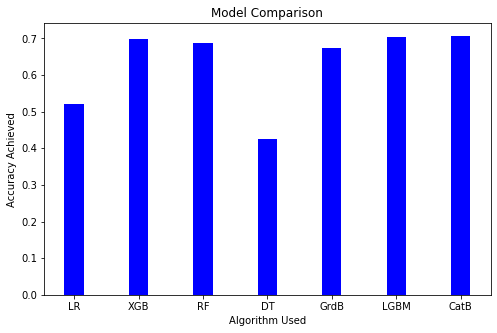

In [45]:
data = {'LR':model_1.score(X_test, y_test),
        'XGB':model_2.score(X_test, y_test),
        'RF':model_3.score(X_test, y_test),
        'DT':model_4.score(X_test, y_test),
        'GrdB':model_5.score(X_test, y_test),
        'LGBM':model_6.score(X_test, y_test),
        'CatB':model_7.score(X_test, y_test)}

algo = list(data.keys())
acc = list(data.values())
  
fig = plt.figure(figsize = (8,5))

# tabulating the results
data1 = [['Linear Regression',model_1.score(X_test, y_test)],
         ['XGBoost',model_2.score(X_test, y_test)],
         ['Random Forest',model_3.score(X_test, y_test)],
         ['Decision Tree',model_4.score(X_test, y_test)],
         ['Gradient Boosting',model_5.score(X_test, y_test)],
         ['Light GBM',model_6.score(X_test, y_test)],
         ['Cat Boost',model_7.score(X_test, y_test)]]

head = ['Algorithm Used','Accuracy Achieved']

print(tabulate(data1, headers=head, tablefmt="grid"))
 
# creating the bar plot
plt.bar(algo, acc, color = 'blue', width = 0.3)
plt.xlabel("Algorithm Used")
plt.ylabel("Accuracy Achieved")
plt.title("Model Comparison")
plt.show()

# Cat Boost Regressor has provided the most accurate results. Predictions are 70.76% accurate.

### Results 

C:\Users\DELL\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


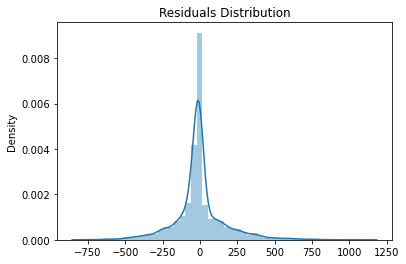

In [46]:
# first, we'll check the distribution of residuals

# getting predictions using Cat Boost Regressor
y_pred = model_7.predict(X_test)

# plotting the graph between the actual and the predicted labels
sns.distplot(y_test-y_pred)
plt.title('Residuals Distribution')
plt.show()

In [47]:
# the residuals are normally distributed, it means that the model's performance is very good

### Visualizing the Accuracy

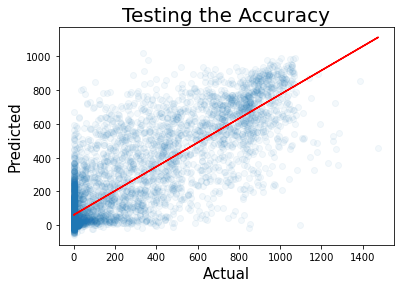

In [48]:
plt.scatter(y_test, y_pred, alpha=0.05)
plt.xlabel('Actual', fontsize=15)
plt.ylabel('Predicted', fontsize=15)   # this is X_test predicted
plt.title('Testing the Accuracy', fontsize=20)
m, b = np.polyfit(y_test, y_pred, 1)
plt.plot(y_test, m*y_test + b, color='red')
plt.show()

# when we create the testing dataset summary, we will use y_test as target and y_pred(which actually is X_test predicted)
# as predictions, and then compute further residuals and differences.

# The alpha uses the blurring concept to show where the maximum points are concentrated and we see they are evenly spread
# after being concentrated initially, and a straight line can be fit.

### Getting the pkl File

In [49]:
import pickle
  
# saving the model as a pickle in a file 
pickle.dump(model_7, open('SolarRadiationPrediction.pkl','wb'))